In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='/content/drive/MyDrive/Deep_learning-datasets', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='/content/drive/MyDrive/Deep_learning-datasets', train=False, download=True, transform=transform)

class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

100%|██████████| 26421880/26421880 [00:01<00:00, 17500216.26it/s]


Extracting /content/drive/MyDrive/Deep_learning-datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Deep_learning-datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 297475.87it/s]


Extracting /content/drive/MyDrive/Deep_learning-datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Deep_learning-datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5613821.66it/s]


Extracting /content/drive/MyDrive/Deep_learning-datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Deep_learning-datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3312206.93it/s]

Extracting /content/drive/MyDrive/Deep_learning-datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Deep_learning-datasets/FashionMNIST/raw



In [ ]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Deep_learning-datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Deep_learning-datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

In [ ]:
for images,labels in train_loader:
  break

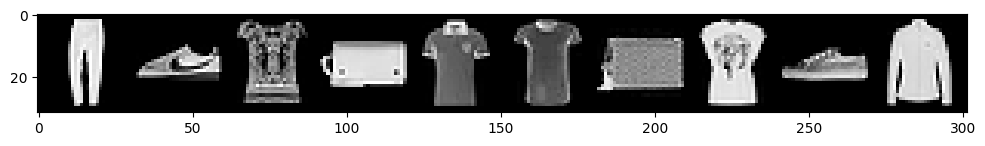

In [ ]:
im = make_grid(images,nrow=10)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Label: [    1     7     6     8     0     0     8     0     7     4]
Class:  Trouser Sneaker Shirt Bag T-shirt T-shirt Bag T-shirt Sneaker Coat


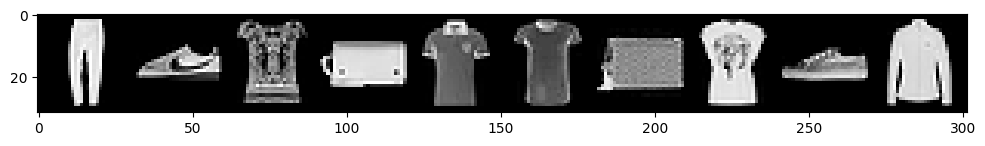

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images,nrow=10)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
conv = nn.Conv2d(1, 1, 5, 1)
for x,labels in train_loader:
    print('Orig size:',x.shape)
    break
x = conv(x)
print('Down size:',x.shape)

Orig size: torch.Size([10, 1, 28, 28])
Down size: torch.Size([10, 1, 24, 24])


In [ ]:
x = F.max_pool2d(x, 2, 2)
print('Down size:',x.shape)

Down size: torch.Size([10, 1, 12, 12])


In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

torch.manual_seed(101)
model = ConvolutionalNetwork()

In [ ]:
for params in model.parameters():
  print(params.numel())

54
6
864
16
48000
120
10080
84
840
10


In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if b%600 == 0:
      print(f'Epoch {i} Batch {b} Loss {loss.item()}')
  train_losses.append(loss.item())
  train_correct.append(trn_corr)
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()
  loss = criterion(y_val, y_test)
  test_losses.append(loss.item())
  test_correct.append(tst_corr)
current_time = time.time()
total_time = current_time - start_time
print(f'Training took {total_time/60} minutes')

Epoch 0 Batch 600 Loss 1.0576214790344238
Epoch 0 Batch 1200 Loss 0.7970748543739319
Epoch 0 Batch 1800 Loss 0.7302319407463074
Epoch 0 Batch 2400 Loss 0.2402336597442627
Epoch 0 Batch 3000 Loss 0.31936484575271606
Epoch 0 Batch 3600 Loss 0.7441314458847046
Epoch 0 Batch 4200 Loss 0.4809443950653076
Epoch 0 Batch 4800 Loss 0.13909125328063965
Epoch 0 Batch 5400 Loss 0.34160882234573364
Epoch 0 Batch 6000 Loss 0.3461466431617737
Epoch 1 Batch 600 Loss 0.2038058042526245
Epoch 1 Batch 1200 Loss 0.5851181745529175
Epoch 1 Batch 1800 Loss 0.3703283667564392
Epoch 1 Batch 2400 Loss 0.15840525925159454
Epoch 1 Batch 3000 Loss 0.25853225588798523
Epoch 1 Batch 3600 Loss 0.3786236643791199
Epoch 1 Batch 4200 Loss 0.16635961830615997
Epoch 1 Batch 4800 Loss 0.6257714629173279
Epoch 1 Batch 5400 Loss 0.31241729855537415
Epoch 1 Batch 6000 Loss 0.23993699252605438
Epoch 2 Batch 600 Loss 0.9482365846633911
Epoch 2 Batch 1200 Loss 0.953350841999054
Epoch 2 Batch 1800 Loss 0.0348040871322155
Epoch 2

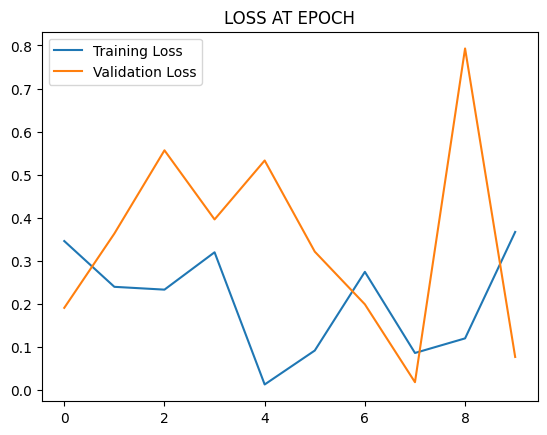

In [ ]:
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label='Validation Loss')
plt.title('LOSS AT EPOCH')
plt.legend()

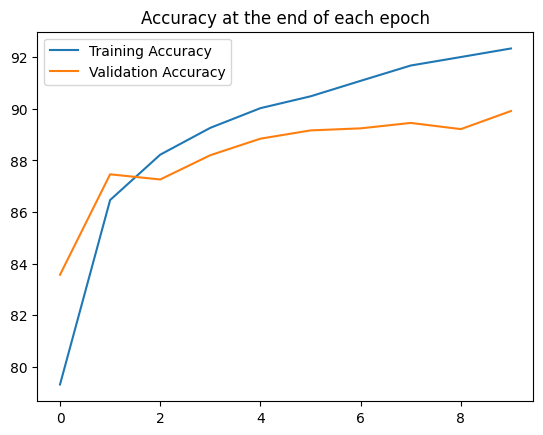

In [ ]:
plt.plot([t/600 for t in train_correct],label='Training Accuracy')
plt.plot([t/100 for t in test_correct],label='Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [ ]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

In [ ]:
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.2f}%')

Test accuracy: 8991/10000 =   89.91%


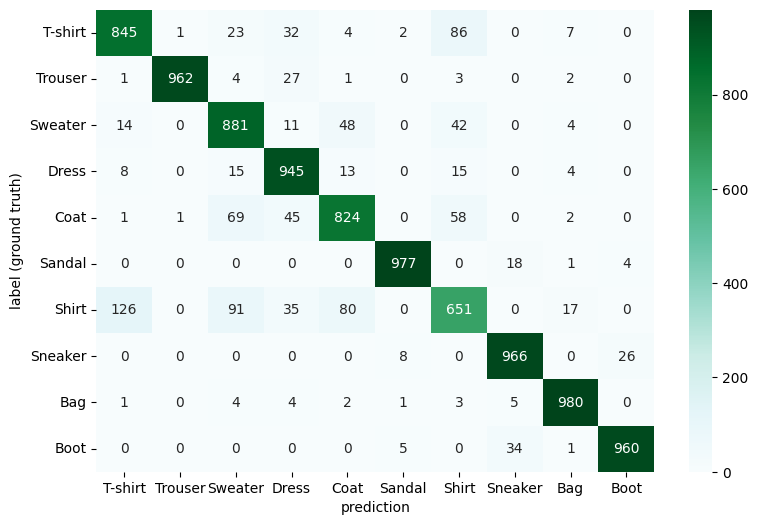

In [ ]:
import seaborn as sns

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

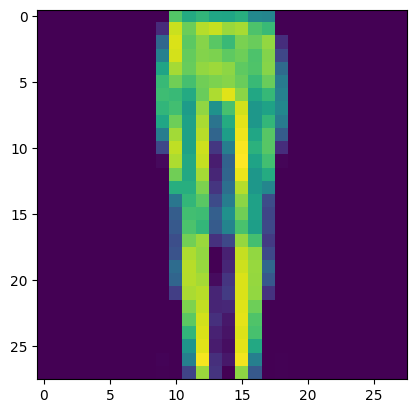

In [ ]:
plt.imshow(test_data[6767][0].reshape(28,28))

In [ ]:
class_names[test_data[6767][1]]

'Trouser'

In [ ]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[6767][0].view(1,1,28,28))

In [ ]:
class_names[new_prediction[-1].argmax().item()]

'Trouser'